# GNSS and temperature analyzer for minions

## Modules

In [4]:
import scipy as scµ

In [5]:
import csv
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

In [6]:
import numpy as np
import utm

## Homemade functions

### Importing csv function

In [7]:
def csv_export(filename, fields, ROW) :
    with open(filename, 'w') as csvfile: 
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 

        # writing the fields 
        csvwriter.writerow(fields) 

        # writing the data rows 
        csvwriter.writerows(ROW)

### UTM list converter

In [8]:
def utm_converter(X, Y) :
    outX = []
    outY = []
    for i in range(len(X)) :
        UTM = utm.from_latlon(Y[i],X[i])
        outX.append(UTM[1]), outY.append(UTM[0])
    return outX, outY

### Log file reader

In [9]:
def nodes_gnss_temp(root, nodenbr, startdate = None, enddate = None, utm_bool = False) :
    TEMP = []
    TEMPUTC = []
    GNSSUTC = []
    LAT = []
    LONG = []
    COMPASS = []
    TILT = []
    ALTI = []

    LATUTM = []
    LONGUTM = []
    
    acttemp = 0
    actgnss = 0
    with open(root+'DigiSolo_'+nodenbr+'.LOG') as file :
        readcsv = csv.reader(file, delimiter=' ')
        line = 0
        for row in readcsv :
            if row != [] :
                if row[0].startswith('[Temperature') :
                    acttemp = 1 #active la boucle actemp
                if acttemp == 1 :
                    if row[0] == 'UTC' :
                        TEMPUTC.append(np.datetime64(row[-1].replace(',','T').replace('/','-')))
                    elif row[0] == 'Temperature' :
                        TEMP.append(float(row[2]))
                        acttemp = 0
                if len(row) > 3 and row[3] == 'GPS' and row[4]=='Synchronization' :
                    actgnss = 1 #active la boucle actgnss
                if actgnss == 1 :
                    if row[0] == 'Latitude':
                        lat = float(row[-1])
                        #WGS 84
                        LAT.append(lat)
                        LONG.append(long)
                        #UTM
                        UTM = utm.from_latlon(lat,long, force_zone_letter='W', force_zone_number=28)
                        LATUTM.append(UTM[0])
                        LONGUTM.append(UTM[1])
                        
                    elif row[0] == 'Longitude' :
                        long = float(row[-1])
                    elif row[0] == 'eCompass' :
                        COMPASS.append(float(row[-1]))
                    elif row[0] == 'UTC' :
                        GNSSUTC.append(np.datetime64(row[-1].replace(',','T').replace('/','-')))
                    elif row[0] == 'Tilted' :
                        TILT.append(float(row[-1]))
                    elif row[0] == 'Altitude' :
                        if row[-1] == 'Unknown' :
                            ALTI.append(ALTI[-1])
                        else :
                            ALTI.append(float(row[-1]))
                        actgnss = 0
    if startdate != None :
        startdate = np.datetime64(startdate)
        GNSSUTC = np.array(GNSSUTC)
        binaryGPS = np.where(GNSSUTC > startdate, 1, 0)
        binaryTEMP = np.where(TEMPUTC > startdate, 1, 0)
        if enddate != None :
            enddate = np.datetime64(enddate)
            GNSSUTC = np.array(GNSSUTC)
            binGPSend = np.where(GNSSUTC < enddate, 1, 0)
            binaryGPS *= binGPSend
            
            TEMPUTC = np.array(TEMPUTC)
            binTEMPend = np.where(TEMPUTC < enddate, 1, 0)
            binaryTEMP *= binTEMPend
            
            #print(binend)
            #print(binary)
        
   ##### Extracting the "needed" data based on the date binary array #####     
        
        #WGS84
        LAT = np.extract(binaryGPS, LAT)
        LONG =  np.extract(binaryGPS, LONG)
        #UTM
        LATUTM = np.extract(binaryGPS, LATUTM)
        LONGUTM =  np.extract(binaryGPS, LONGUTM)
                
        ALTI =  np.extract(binaryGPS, ALTI)
        GNSSUTC =  np.extract(binaryGPS, GNSSUTC)
        TILT =  np.extract(binaryGPS, TILT)
        COMPASS = np.extract(binaryGPS, COMPASS)
        
        TEMPUTC = np.extract(binaryTEMP, TEMPUTC)
        TEMP = np.extract(binaryTEMP, TEMP)
        
    ##### Save the position of the nodes over time #####                    
    
    POS = []
    headers = ['TIME','LONG','LAT']
    for i in range(len(LONG)) :
        POS.append([GNSSUTC[i],LONG[i],LAT[i]])
    
    csv_export('./temp_pos_nodes/pos_'+nodenbr+'.csv', headers, POS)
    
    outTEMP = []
    headers = ['TIME','TEMPERATURE']
    for i in range(len(TEMP)) :
        outTEMP.append([TEMPUTC[i],TEMP[i]])
    
    csv_export('./temp_pos_nodes/temp_'+nodenbr+'.csv', headers, outTEMP) 
    
    if utm_bool == True :
        return TEMP, TEMPUTC, GNSSUTC, LATUTM, LONGUTM, ALTI, COMPASS, TILT    
    
    return TEMP, TEMPUTC, GNSSUTC, LAT, LONG, ALTI, COMPASS, TILT

### Export tilt inclination

In [10]:
root = 'D:\\MEMOIRE\\DigiSoloLOG\\'
#N = ['20773', '20781', '20769', '20774', '20739', '20754']
N = ['20732','20736','20740','20742','20746','20750','20751','20753','20755','20756','20759','20760','20762','20768','20780']
for node in N :
    A = '2022-05-28'
    B = '2022-06-09'
    TEMP, TEMPUTC, GNSSUTC, LAT, LONG, ALTI, COMPASS, TILT = nodes_gnss_temp(root, node, startdate=A, enddate=B)
    for i in range(len(TILT)) :
        if TILT[i] > 4 :
            itilt = i
            break
    
    d = {'time': GNSSUTC, 'tilt': TILT, 'treshold_tilt' : [GNSSUTC[itilt]]*len(TILT)}
    a = pd.DataFrame(data=d)
    a.to_csv('./temp_pos_nodes/tilt_4530%s.csv'%node)

### Function to export into a readable format for PCA notebook

In [6]:
def gnss_export_pca(root,sensors) :
    output = []
    actgnss = 0
    for sensor in sensors :
        tempL = []
        with open(root+'DigiSolo_'+sensor+'.LOG') as file :
            readcsv = csv.reader(file, delimiter=' ')
            line = 0
            for row in readcsv :
                if len(row) > 3 and row[0] == 'Serial' and row[1] == 'Number' :
                    serial = int(row[-1])
                if len(row) > 3 and row[3] == 'GPS' and row[4]=='Synchronization' :
                    actgnss = 1 #active la boucle actgnss
                    tempL.append(serial)
                    tempL.append('GPS Synchronization')
                if actgnss == 1 :
                    if row[0] == 'Longitude' :
                        tempL.append(row[-1])
                    if row[0] == 'Latitude' :
                        tempL.append(row[-1])
                    if row[0] == 'Altitude' :
                        tempL.append(row[-1])
                    if row[0] == 'Satellite' :
                        if row[1] == 'Number' :
                            tempL.append(row[-1])
                        if row[1] == 'ID' :
                            tempL.append(row[-1])
                    if row[0] == 'GPS' and row[1] == 'Strength' :
                        tempL.append(row[-1])
                    if row[0] == 'RTC' :
                        tempL.append(row[-1])
                        actgnss = 0
                        output.append(tempL)
                        tempL = []
    return output, serial

In [94]:
root = 'D:\\MEMOIRE\\DigiSoloLOG\\'
stt = 20769

In [95]:
output, sn = gnss_export_pca(root,['20773','20774','20769','20781','20739','20754'])
head = ['receiver_sn','status','satellite_number','satellite_strength','satellite_id','longitude','latitude','altitude','record_time']
df = pd.DataFrame(output,columns = head)

In [96]:
df

,receiver_sn,status,satellite_number,satellite_strength,satellite_id,longitude,latitude,altitude,record_time
0,453020773,GPS Synchronization,08,"47,45,44,39,37,37,34,32","3,17,19,28, 1,14,12,21",-17.830306000,64.147668000,837.3,"2022/05/07,18:34:37"
1,453020773,GPS Synchronization,10,"47,47,45,45,42,41,41,41,35,31","1, 3,17,19,21,22,28,32,14,12",-17.830292167,64.147669667,836.1,"2022/05/07,18:42:46"
2,453020773,GPS Synchronization,11,"47,46,46,46,42,41,41,40,35,33,33","3, 1,17,19,21,22,32,28,12, 4,14",-17.830287833,64.147668667,836.2,"2022/05/07,18:50:58"
3,453020773,GPS Synchronization,11,"47,46,46,45,41,41,40,39,37,37,34","3,17,19, 1,21,22,32,28, 4,12, 6",-17.830290667,64.147665000,835.1,"2022/05/07,18:59:10"
4,453020773,GPS Synchronization,11,"47,46,46,44,40,40,39,39,39,38,37","3,17,19, 1,21,22, 4,12,32,28, 6",-17.830290667,64.147667667,835.3,"2022/05/07,19:07:22"
...,...,...,...,...,...,...,...,...,...
30543,453020754,GPS Synchronization,11,"47,40,38,38,37,36,35,33,27,27,24","12, 2,22,32,25,31,11, 3,24,29, 6",-17.265531833,64.406911500,1737.5,"2022/06/05,06:19:34"
30544,453020754,GPS Synchronization,10,"43,42,42,38,38,35,34,33,31,27","32,22,25, 3,12, 2,11,31, 6,19",-17.265544833,64.406905000,1735.4,"2022/06/05,06:27:34"
30545,453020754,GPS Synchronization,10,"40,39,39,38,37,37,35,35,35,32","32, 2,25,22,29,31, 3,11,12, 6",-17.265567500,64.406886333,1731.5,"2022/06/05,06:35:34"
30546,453020754,GPS Synchronization,11,"40,39,39,39,38,38,37,35,34,33,30","32, 2,22,29,12,25,31, 3,11,26, 6",-17.265595000,64.406905500,1728.7,"2022/06/05,06:43:47"


In [97]:
df.to_csv('./pca-gnss/node-%s.csv'%'nodes-ablation', sep=';')

## Read DigiSolo.LOG

In [11]:
root = 'D:\\MEMOIRE\\DigiSoloLOG\\'
nodenbr = '20773'
A = '2022-05-08'
B = '2022-06-03'
#A = datetime.datetime(2022,5,29)
#B = datetime.datetime(2022,6,2)
TEMP, TEMPUTC, GNSSUTC, LAT, LONG, ALTI, COMPASS, TILT = nodes_gnss_temp(root, nodenbr, A, B,utm_bool=True)


### Plots

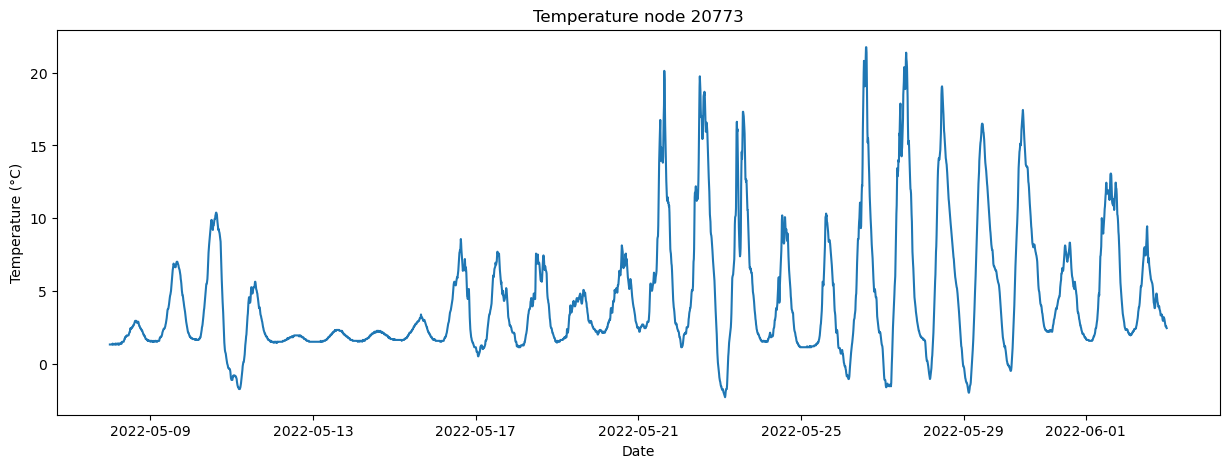

In [12]:
plt.figure(figsize=(15,5))
plt.plot(TEMPUTC, TEMP)
plt.title('Temperature node '+nodenbr)
plt.xlabel('Date')
plt.ylabel("Temperature (°C)")
plt.show()

Text(0, 0.5, 'Latitude UTM')

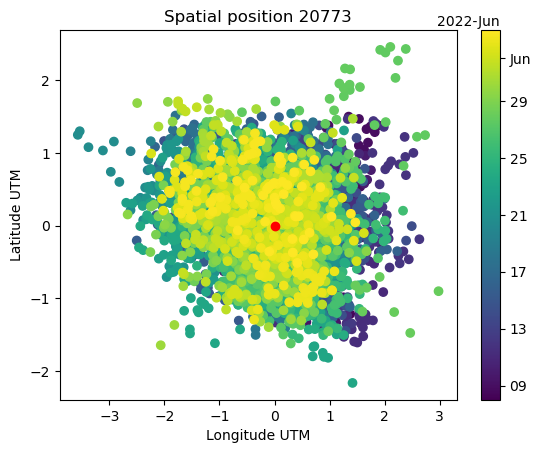

In [13]:
rLONG = LONG-np.mean(LONG)
rLAT = LAT- np.mean(LAT)

plt.figure()
plt.scatter(rLONG, rLAT, c=mdates.date2num(GNSSUTC))
cb = plt.colorbar()
loc = mdates.AutoDateLocator()
cb.ax.yaxis.set_major_locator(loc)
cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
plt.scatter(0, 0, c='r')
plt.title('Spatial position '+nodenbr)
#plt.xlim([-10,10])
#plt.ylim([-10,10])
plt.xlabel('Longitude UTM')
plt.ylabel('Latitude UTM')

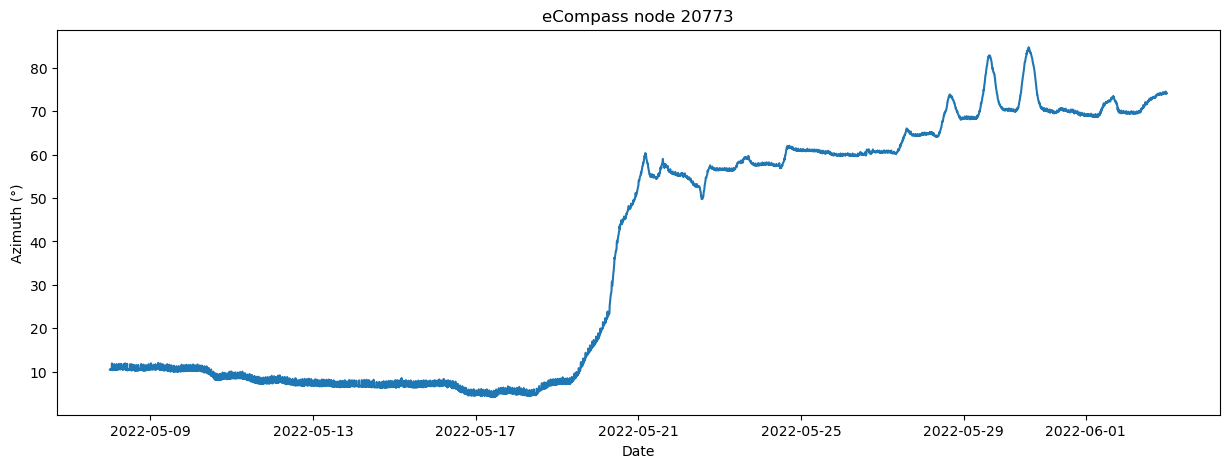

In [14]:
plt.figure(figsize=(15,5))
plt.plot(GNSSUTC, COMPASS)
plt.title('eCompass node '+nodenbr)
plt.xlabel('Date')
plt.ylabel("Azimuth (°)")
plt.show()

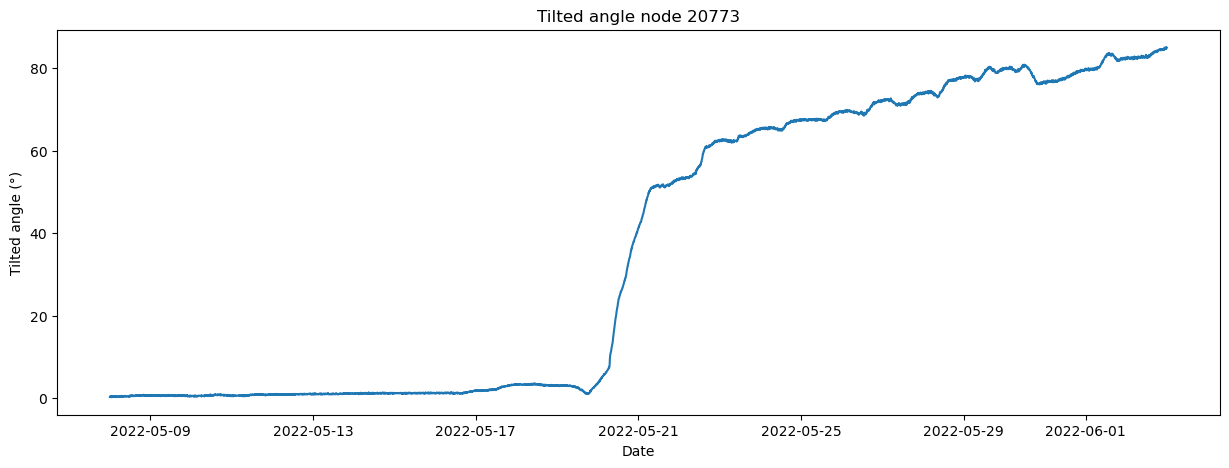

In [15]:
plt.figure(figsize=(15,5))
plt.plot(GNSSUTC, TILT)
plt.title('Tilted angle node '+nodenbr)
plt.xlabel('Date')
plt.ylabel("Tilted angle (°)")
plt.show()

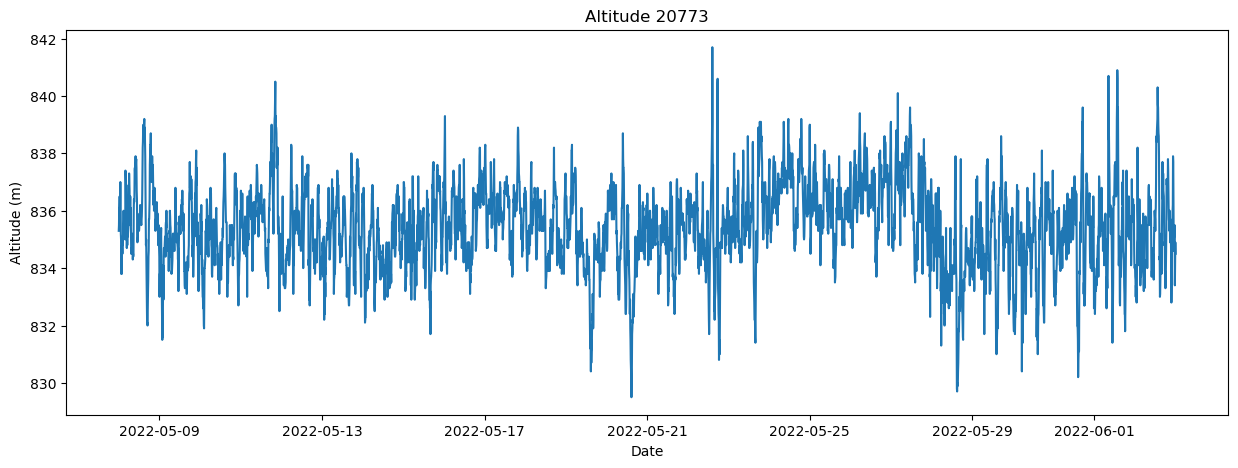

In [16]:
plt.figure(figsize=(15,5))
plt.plot(GNSSUTC, ALTI)
plt.title('Altitude '+nodenbr)
plt.xlabel('Date')
plt.ylabel("Altitude (m)")
plt.show()

## GPS error correction

### Function to determine the slope between to point

In [17]:
"Fonction pour déterminer une equation de droite à partir de deux points"
def eqfinder(LMED, UTCMED) :
    EQL = []
    for i in range(1,len(LMED)) :
        slope = (LMED[i] - LMED[i-1])/(3600) #calcule de pente de la slope en seconde
        origin = LMED[i-1]
        dt = UTCMED[i]
        EQL.append([slope, origin, dt])
    return EQL

### Median for every hour

In [63]:
"Fonction qui fait la mediane sur une succession de points"
def medGPS(GNSSUTC, rL) :
    hours = 1
    index = 0
    ind0 = 0

    LMED = [np.median(rL)]

    init = GNSSUTC[0].astype(datetime.datetime)

    UTCMED = [init]

    for timegps in GNSSUTC :
        dt = init + datetime.timedelta(hours=hours)
        if timegps >= dt and index > 0 :
            median = np.median(rL[ind0:index])
            LMED.append(median)        
            UTCMED.append(init + datetime.timedelta(hours=hours))        

            ind0 = index
            hours += 1
        index += 1

    LMED.append(np.median(rL))        
    UTCMED.append(GNSSUTC[-1].astype(datetime.datetime))      
    
    return LMED, UTCMED


### Smoothing median/mode function

In [64]:
"""
Fonction qui fait la mode ou la mediane sur une succession de points
output[0] = mode/median
output[1] = std
output[2] = time
"""
def moedGPS_linear(rL, time,nbrpt = None, mode = False) :
    if nbrpt == None :
        nbrpt = 8
    output = [[],[],[]] #0 is mode
    for i in range(len(rL)-nbrpt) :
        if i < len(rL) - nbrpt :
            hist, bin_edges = np.histogram(rL[i:i+nbrpt], density=True)
            if mode == True :
                idxmax = hist.argmax()
                mode_np = bin_edges[idxmax]
            else :
                med_np = np.median(rL[i:i+nbrpt])
                mode_np = med_np
            output[0].append(mode_np)
            output[1].append(np.std(rL[i:i+nbrpt]))
            output[2].append(time[i])
    return np.array(output)

### Extracting the GNSS error of the static node

In [68]:
LATMED, UTCMED = medGPS(GNSSUTC, rLAT)
LATLIN = moedGPS_linear(rLAT,GNSSUTC)
EQLAT = eqfinder(LATMED, UTCMED)

LONGMED, UTCMED = medGPS(GNSSUTC, rLONG)
LONGLIN = moedGPS_linear(rLONG,GNSSUTC)
EQLONG = eqfinder(LONGMED, UTCMED)

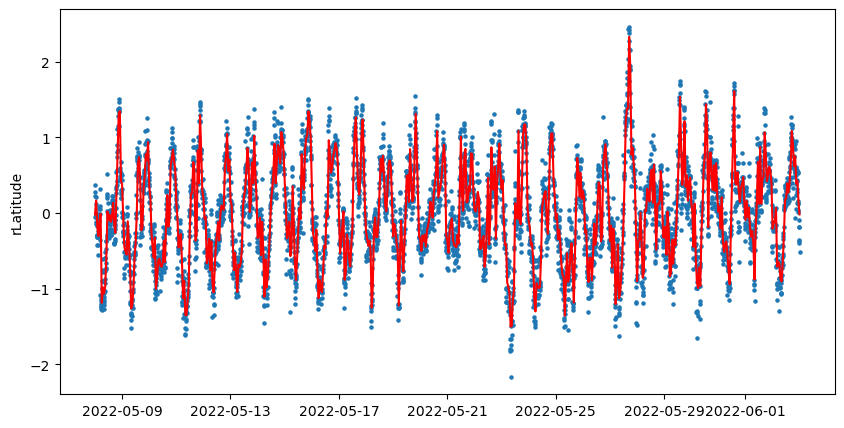

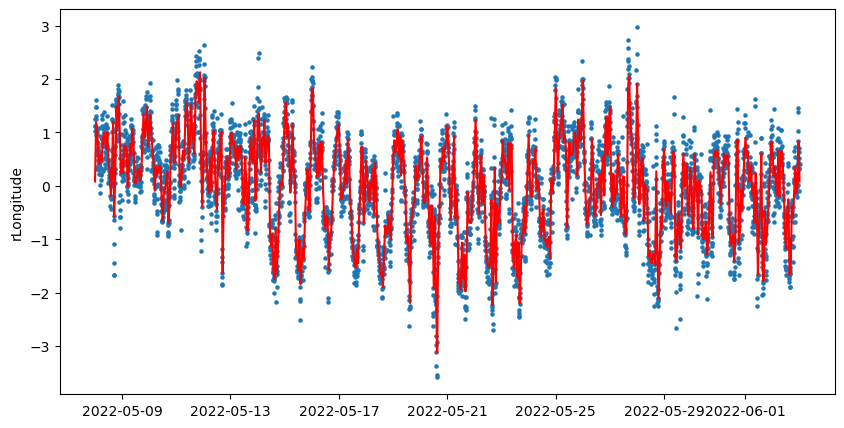

In [74]:
plt.figure(figsize=(10,5))
plt.scatter(GNSSUTC, rLAT, s=5)
plt.plot(UTCMED,LATMED, c='r')
#plt.plot(LATLIN[2], LATLIN[0], c='green')
plt.ylabel('rLatitude')
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(GNSSUTC, rLONG, s=5)
plt.plot(UTCMED,LONGMED, c='r')
#plt.plot(GNSSUTC, LONGLIN, c='green')
plt.ylabel('rLongitude')
plt.show()

### Importing a moving node

In [49]:
root = 'D:\\MEMOIRE\\DigiSoloLOG\\'
nodenbr = '20769'
A = '2022-05-08'
B = '2022-06-03'
#A = datetime.datetime(2022,5,29)
#B = datetime.datetime(2022,6,2)
TEMP74, TEMPUTC74, GNSSUTC74, LAT74, LONG74, ALTI74, COMPASS74, TILT74 = nodes_gnss_temp(root, nodenbr, A, B,utm_bool=True)

### Scatter plot of the moving node and compared to the static node (red)

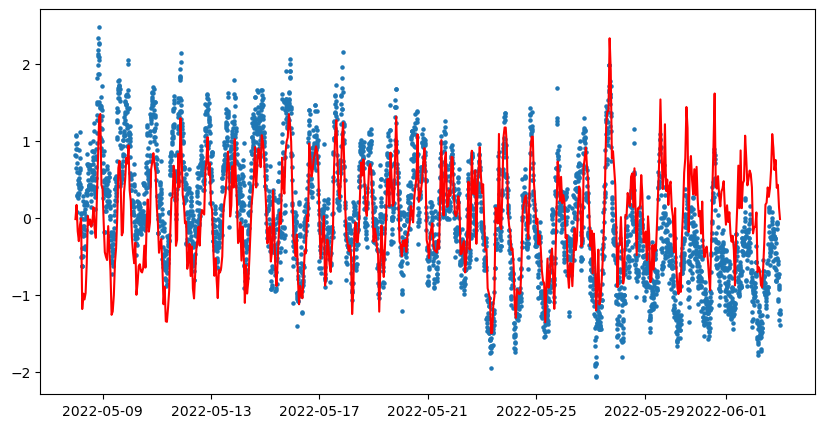

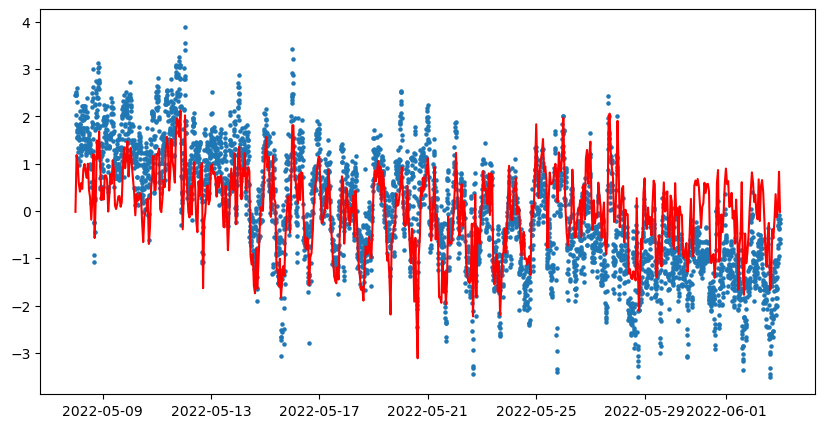

In [50]:
rLONG74 = LONG74 -np.mean(LONG74)
rLAT74 = LAT74 - np.mean(LAT74)

plt.figure(figsize=(10,5))
plt.plot(UTCMED,LATMED, c='r')
plt.scatter(GNSSUTC74, rLAT74, s=5)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(UTCMED,LONGMED, c='r')
plt.scatter(GNSSUTC74, rLONG74, s=5)
plt.show()


### Correction of the position based the equation line between two 1 hour median position 

In [51]:
def utc_corr(rLAT, EQLAT, GNSSUTC) :
    j = 0

    dLAT = []

    for i in range(len(rLAT)) :
        t = GNSSUTC[i].astype(datetime.datetime)
        #print(t,EQLAT[j][2])
        if t > EQLAT[j][2] :
            j += 1
        if j < len(EQLAT) and t <= EQLAT[j][2]:
            dx =  (EQLAT[j][2]-t) #position sur l'équation
            x = 3600 - dx.seconds
            y = EQLAT[j][0] * x + EQLAT[j][1]
            dLAT.append(rLAT[i] - y)
            #print(i)
        #print('h : %s, rLat : %f, y : %f, lat corrige : %f' %(str(GNSSUTC[i]),rLAT74[i], y, dLAT[i]))
    return(dLAT)

In [ ]:
dLAT = utc_corr(rLAT74, EQLAT, GNSSUTC74)
dLONG = utc_corr(rLONG74, EQLONG, GNSSUTC74)

In [52]:
if rLAT74.shape[0] >= LATLIN.shape[1] :
    maxlen = LATLIN.shape[1]
    corrLATLIN = rLAT74[0:maxlen]-LATLIN[0]
    corrLONGLIN = rLONG74[0:maxlen]-LONGLIN[0]
else :
    maxlen = rLAT74.shape[0]
    corrLATLIN = rLAT74-LATLIN[0][0:maxlen]
    corrLONGLIN = rLONG74-LONGLIN[0][0:maxlen]

In [53]:
len(GNSSUTC74), len(dLAT)

(4585, 4585)

### Plotting the corrected (blue) and smoothed (red) position

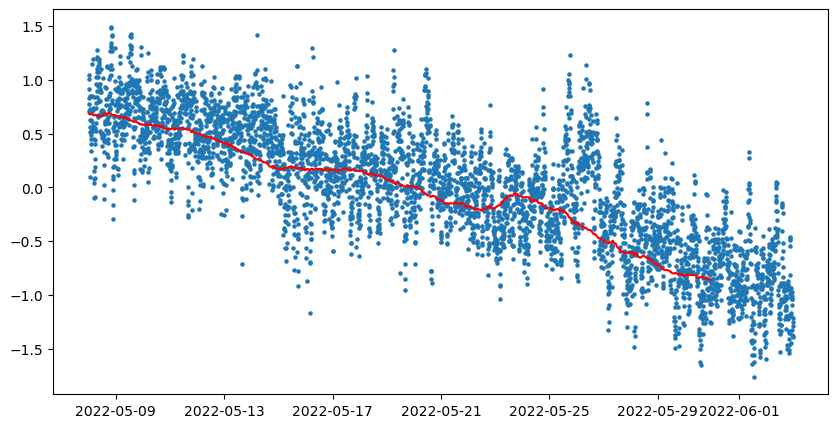

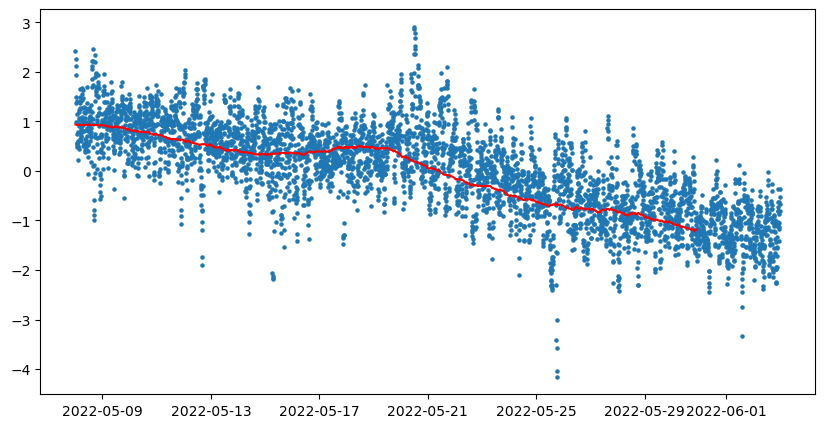

In [60]:
tt = int(72*60/8) #number of points (xx hours * 60 minutes / 8 minutes) 8 minutes : frequency of the GPS
end = len(GNSSUTC74)-0
dLATLin = moedGPS_linear(dLAT,GNSSUTC74,nbrpt=tt)
dLONGLin = moedGPS_linear(dLONG,GNSSUTC74,nbrpt=tt)

end = len(GNSSUTC74)-0
plt.figure(figsize=(10,5))
plt.plot(dLATLin[2], dLATLin[0], c='r')
plt.scatter(GNSSUTC74[0:end], dLAT, s=5)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(dLONGLin[2], dLONGLin[0], c='r')
plt.scatter(GNSSUTC74[0:end], dLONG, s=5)
plt.show()

### Comparing the different approaches

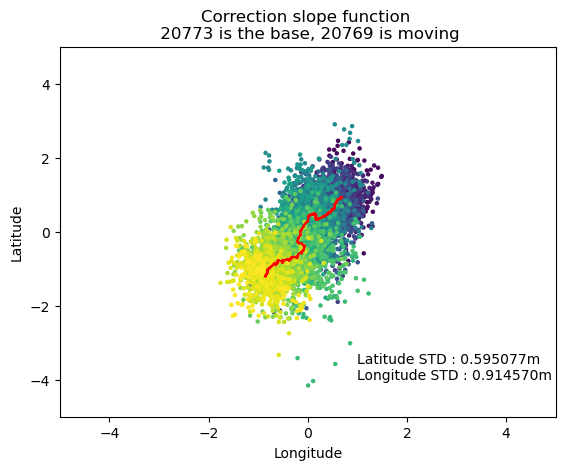

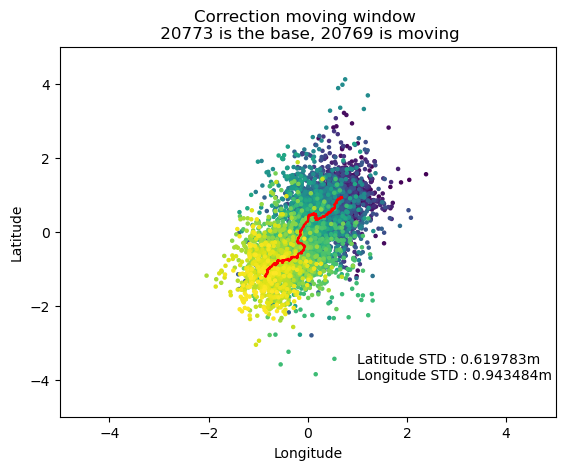

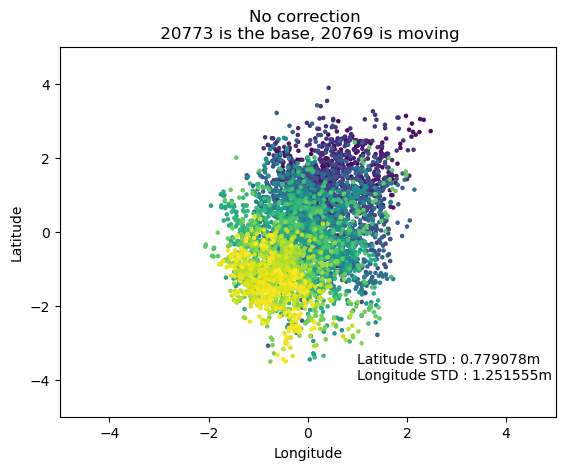

In [67]:
end = len(GNSSUTC74)-0
std_dlat = np.std(dLAT)
std_dlong = np.std(dLONG)
plt.scatter(dLAT, dLONG, s=5, c=GNSSUTC74[0:end])
plt.plot(dLATLin[0], dLONGLin[0], c='r')
plt.text(1,-4,("Latitude STD : %fm \nLongitude STD : %fm" %(std_dlat,std_dlong)))
plt.xlim((-5,5))
plt.ylim((-5,5))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Correction slope function \n 20773 is the base, %s is moving' %nodenbr)
plt.show()


end = len(GNSSUTC74)-1
std_latlin = np.std(corrLATLIN)
std_longlin = np.std(corrLONGLIN)
plt.scatter(corrLATLIN, corrLONGLIN, s=5, c=GNSSUTC74[0:maxlen])
plt.plot(dLATLin[0], dLONGLin[0], c='r')
plt.text(1,-4,("Latitude STD : %fm \nLongitude STD : %fm" %(std_latlin,std_longlin)))
plt.xlim((-5,5))
plt.ylim((-5,5))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Correction moving window \n 20773 is the base, %s is moving' %nodenbr)
plt.show()

std_rlat74 = np.std(rLAT74)
std_rlong74 = np.std(rLONG74)
plt.scatter(rLAT74, rLONG74, s=5, c=GNSSUTC74)
plt.text(1,-4,("Latitude STD : %fm \nLongitude STD : %fm" %(std_rlat74,std_rlong74)))
plt.xlim((-5,5))
plt.ylim((-5,5))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('No correction \n 20773 is the base, %s is moving' %nodenbr)
plt.show()

### Minions velocity

In [185]:
def speed(X,time=None, dt = 8*60) :
    V = []
    dti = dt
    for i in range(1,len(X)) :
        dx = X[i] - X[i-1]
        if dt == None :
            dti = time[i].astype(datetime.datetime) - time[i-1].astype(datetime.datetime)
            dti = dti.seconds
        speed = dx/dti
        V.append(speed)
        #calcule d'erreur voir chap3 SKOOG
        #std_dx = np.sqrt(stdX[i]+stdX[i-1])
        #std_dt = np.sqrt(.5+.5)
        #stdV = np.sqrt((std_dx/dx)**2+(std_dt/dt.seconds)**2)*speed
        #V[1].append(stdV)
    return np.array(V)

In [117]:
Vx = speed(dLONGLin[0],dLONGLin[1],dLONGLin[2])
Vy = speed(dLATLin[0],dLATLin[1],dLATLin[2])
Vtime = dLONGLin[2]

In [118]:
V = np.sqrt(Vx**(2)+Vy**(2))
Vtime = dLONGLin[2]
VLin = moedGPS_linear(V,Vtime,nbrpt=tt)

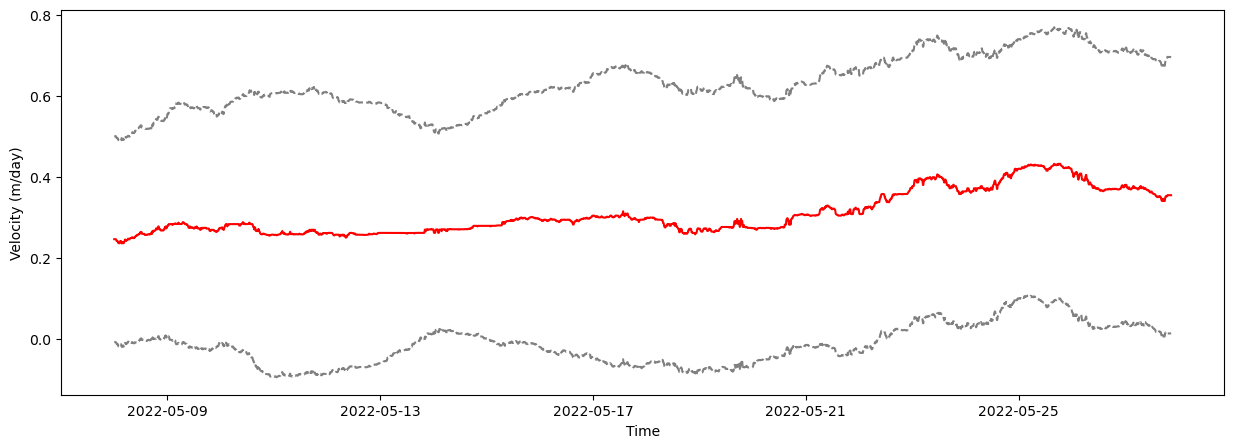

In [119]:
plt.figure(figsize=(15,5))
plt.xlabel('Time')
plt.ylabel('Velocity (m/day)')
#plt.plot(GNSSUTC74[0:end],stdLONGLin*2)
Vhour = VLin[0]*3600*24
Vstd = VLin[1]*3600*24
plt.plot(VLin[2], Vhour,c='r')
plt.plot(VLin[2],Vhour+Vstd, c='grey', linestyle='--')
plt.plot(VLin[2],Vhour-Vstd, c='grey', linestyle='--')
#plt.ylim((0,1))

## Multistations plot

In [52]:
def hist_curve(a, bins=None) :
    if bins == None :
        bins = 100
        
    Y, X = np.histogram(a, bins=100)
    #print(len(X), len(Y))
    centerX = []
    for i in range(len(X)-1) :
        centerX.append((X[i]+X[i+1])/2)
    #print(len(centerX), len(Y))
    return centerX, Y

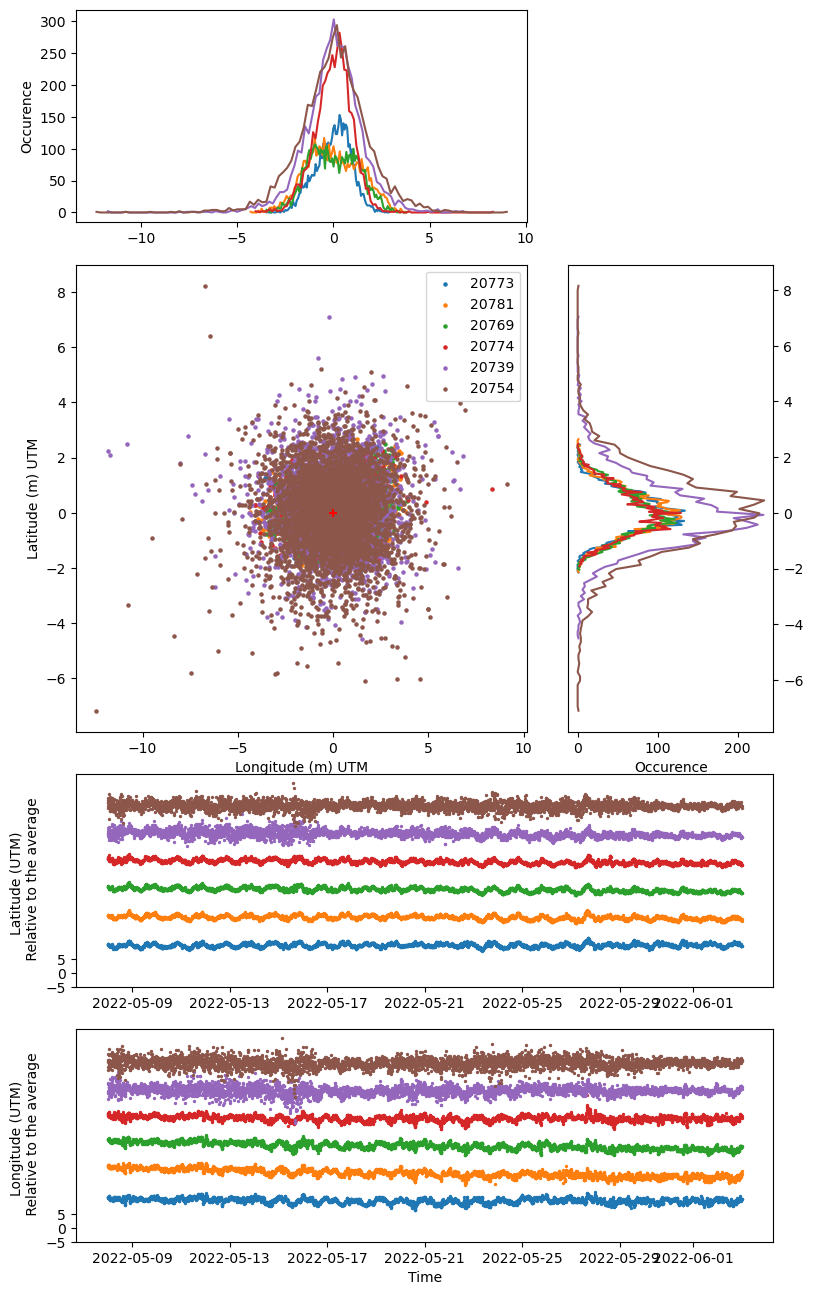

In [53]:
STATION = ['20773', '20781', '20769', '20774', '20739', '20754'] #nodes finnur

#STATION = ['20732', '20736', '20740', '20742', '20746', '20750','20751', '20753', '20755', '20756', '20760', '20762','20768', '20780'] # nodes on vatna

plt.figure(figsize=(9,16))

ax1 = plt.subplot2grid((5,3), (1,0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((5,3), (0,0), colspan=2)
ax3 = plt.subplot2grid((5,3), (1,2), colspan=1,  rowspan=2)
ax4 = plt.subplot2grid((5,3), (3,0), colspan=3)
ax5 = plt.subplot2grid((5,3), (4,0), colspan=3)

ln = 0

seperate = 1

#kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)

for stt in STATION :
    if seperate == 1: 
        ln += 1

    A = datetime.datetime(2022,5,8) # finnur
    B = datetime.datetime(2022,6,3)
    
    #A = datetime.datetime(2022,5,29)
    #B = datetime.datetime(2022,6,2)
    
    TEMP, TEMPUTC, GNSSUTC, LAT, LONG, ALTI, COMPASS, TILT = nodes_gnss_temp(root, stt, A, B, utm_bool=True)
    
    rLONG = LONG-np.mean(LONG)
    rLAT = LAT- np.mean(LAT)
    ax1.scatter(rLONG, rLAT, label=stt, s=5)
    
    histLONG, YLONG = hist_curve(rLONG)
    
    ax2.plot(histLONG, YLONG)
    
    histLAT, YLAT = hist_curve(rLAT)
    
    ax3.plot(YLAT, histLAT)
    
    ax4.scatter(GNSSUTC, rLAT+10*ln, s=2)
    
    ax5.scatter(GNSSUTC, rLONG+10*ln, s=2)

ax1.scatter(0, 0, c='r', marker='+', s=40)
#plt.title('Spatial position all stations')
ax1.set_xlabel('Longitude (m) UTM')
ax1.set_ylabel('Latitude (m) UTM')
ax1.legend()

ax2.set_ylabel('Occurence')
ax3.yaxis.tick_right()
#ax3.tick_params(axis='x', labelrotation=-45)
ax3.set_xlabel('Occurence')

ax4.set_ylabel('Latitude (UTM) \n Relative to the average')
ax4.set_yticks([-5,0,5])


ax5.set_ylabel('Longitude (UTM) \n Relative to the average')
ax5.set_xlabel('Time')
ax5.set_yticks([-5,0,5])

#plt.legend()
plt.show()

## Corrected from PCA

In [250]:
pca = pd.read_csv('./PCA-corrected-locs.txt', delimiter=',')
pca_time = pd.read_csv('./pca-gnss/node-nodes-ablation.csv', delimiter=';')

In [251]:
pca_time.record_time

0        2022/05/07,18:34:37
1        2022/05/07,18:42:46
2        2022/05/07,18:50:58
3        2022/05/07,18:59:10
4        2022/05/07,19:07:22
                ...         
30543    2022/06/05,06:19:34
30544    2022/06/05,06:27:34
30545    2022/06/05,06:35:34
30546    2022/06/05,06:43:47
30547    2022/06/05,06:51:58
Name: record_time, Length: 30548, dtype: object

In [252]:
pca_time.receiver_sn

0        453020773
1        453020773
2        453020773
3        453020773
4        453020773
           ...    
30543    453020754
30544    453020754
30545    453020754
30546    453020754
30547    453020754
Name: receiver_sn, Length: 30548, dtype: int64

In [253]:
stt_bin = np.where(pca['# Station_name'] == 'BE_20781', True, False)
time_bin = np.where(pca_time.receiver_sn == 453020773, True, False)

In [254]:
tpca = np.extract(time_bin, pca_time.record_time)

In [255]:
tpca

array(['2022/05/07,18:34:37', '2022/05/07,18:42:46',
       '2022/05/07,18:50:58', ..., '2022/06/05,01:24:58',
       '2022/06/05,01:33:10', '2022/06/05,01:41:22'], dtype=object)

In [256]:
start = datetime.datetime.strptime('2022-05-08T00:00:00','%Y-%m-%dT%H:%M:%S')
end = datetime.datetime.strptime('2022-05-30T00:00:00','%Y-%m-%dT%H:%M:%S')
timepca = []
for t in tpca :
    tc = datetime.datetime.strptime(t,'%Y/%m/%d,%H:%M:%S')
    if tc > start and tc < end :
        timepca.append(tc)

In [257]:
Upcalon, Upcalat = utm_converter(list(pca.lon), list(pca.lat)) 

In [258]:
latpca = np.extract(stt_bin, Upcalat)
lonpca = np.extract(stt_bin, Upcalon)

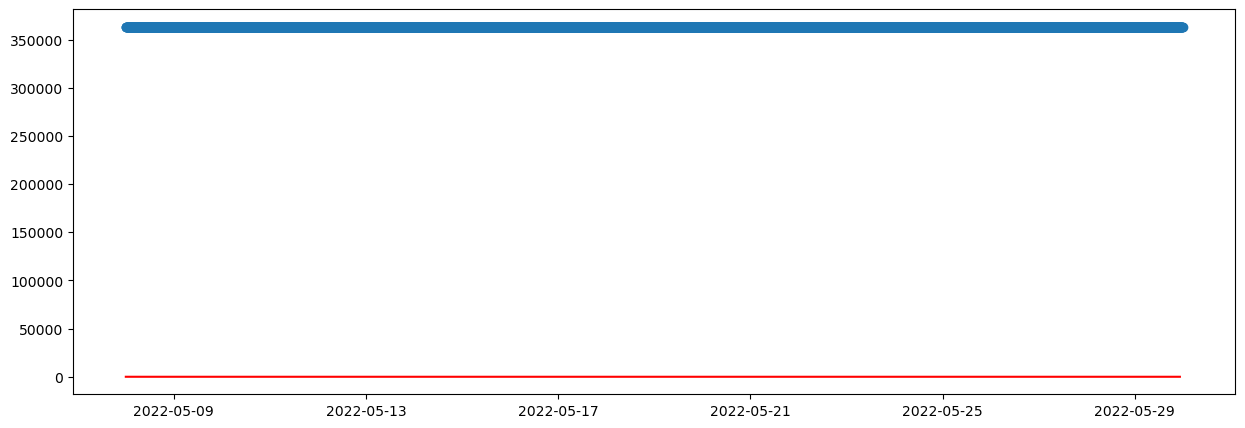

In [274]:
plt.figure(figsize=(15,5))
plt.scatter(timepca,latpca)
plt.plot(dlatpca[2],dlatpca[0],c='r')

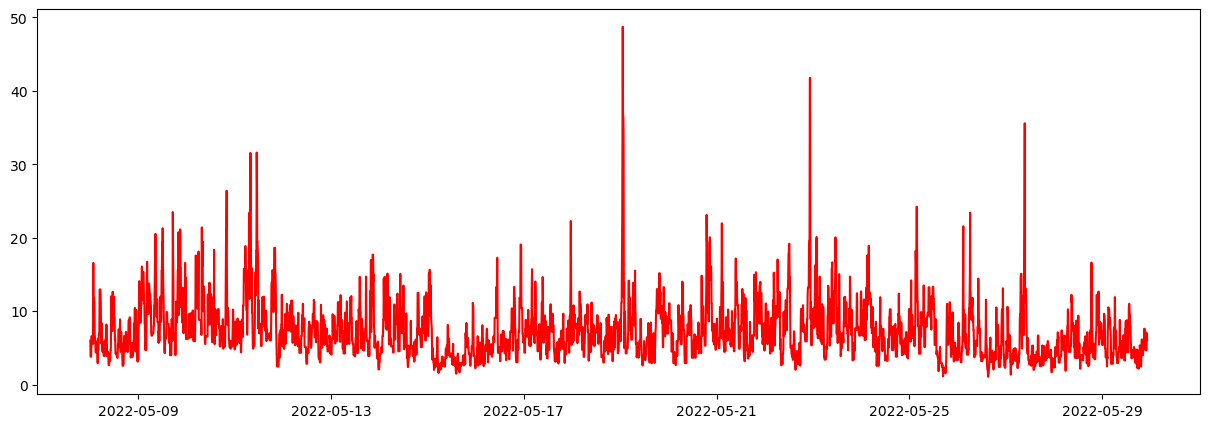

In [273]:
plt.figure(figsize=(15,5))
#plt.scatter(timepca,lonpca)
plt.plot(dlonpca[2],dlonpca[0],c='r')

In [244]:
VyPCA = speed(dlatpca[0],time=dlatpca[2])
VxPCA = speed(dlonpca[0],time=dlonpca[2])

In [245]:
VPCA = np.sqrt(VxPCA**(2)+VyPCA**(2))

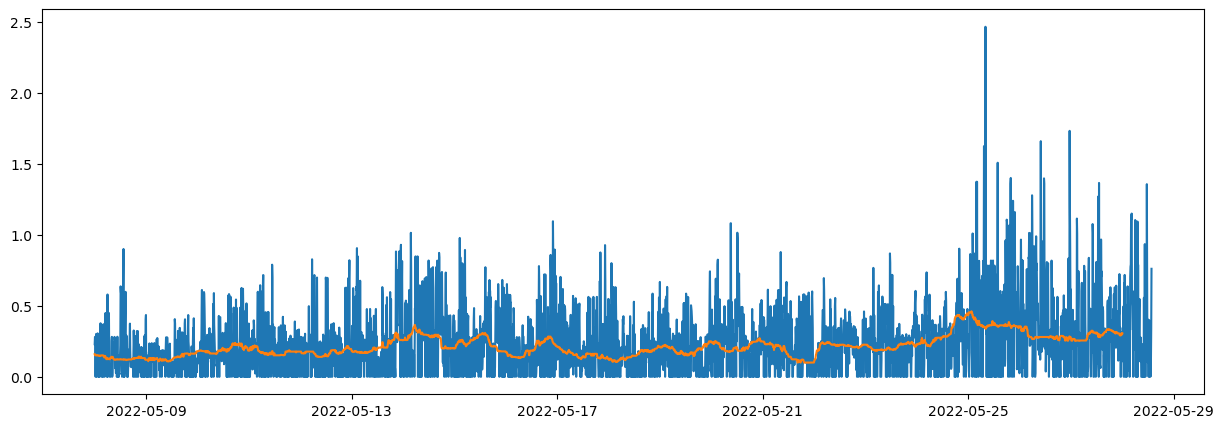

In [247]:
VlinPCA = moedGPS_linear(VPCA ,dlatpca[2][:-1],nbrpt=100)

plt.figure(figsize=(15,5))
plt.plot(dlatpca[2][:-1],VPCA*24*3600)
plt.plot(VlinPCA[2],VlinPCA[0]*24*3600)